In [ ]:
import os
import shutil
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- 0. CONFIGURATION ---
class CFGA:
    # Source paths (adjust these if your raw data is elsewhere)
    raw_img_dir = Path('/content/train_images')
    raw_mask_dir = Path('/content/train_masks')

    root_dir = Path('/content/data_patches')
    patch_size = 512              # Divisible by 32 for ResNet encoder
    batch_size = 16
    lr = 1e-4
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 4               # Set to 0 on Windows to avoid slow multiprocessing startup
    pin_memory = True
    model_name = "UNet_ResNet34_SCSE_ASPP"
    target_limit = 20000
    meta_cache = Path("train_metadata.json")

# --- 1. DATA ORGANIZATION ---
def organize_data():
    """Splits raw images into train/val folders and maps .npy masks."""
    print("📂 Organizing data and splitting into Train/Val...")
    for split in ['train', 'val']:
        for cat in ['authentic', 'forged', 'masks']:
            (CFGA.root_dir / split / cat).mkdir(parents=True, exist_ok=True)

    # Process Authentic
    auth_files = list((CFGA.raw_img_dir / 'authentic').glob('*'))
    a_train, a_val = train_test_split(auth_files, test_size=0.2, random_state=42)

    # Process Forged
    forged_files = list((CFGA.raw_img_dir / 'forged').glob('*'))
    f_train, f_val = train_test_split(forged_files, test_size=0.2, random_state=42)

    def distribute_files(files, split, is_forged=False):
        for fpath in files:
            dest_cat = 'forged' if is_forged else 'authentic'
            shutil.copy(fpath, CFGA.root_dir / split / dest_cat / fpath.name)
            if is_forged:
                mask_name = fpath.stem + '.npy'
                m_path = CFGA.raw_mask_dir / mask_name
                if m_path.exists():
                    shutil.copy(m_path, CFGA.root_dir / split / 'masks' / mask_name)

    distribute_files(a_train, 'train')
    distribute_files(a_val, 'val')
    distribute_files(f_train, 'train', is_forged=True)
    distribute_files(f_val, 'val', is_forged=True)
    print("✅ Transfer Complete.")

# --- 2. TRAINING PATCH SCANNER ---
def scan_and_visualize_train(root_dir, patch_size, target_limit):
    """Scans TRAIN folder using exact stride and threshold logic."""
    print(f"\n🔍 Scanning Train patches (Size: {patch_size})...")
    train_base = root_dir / "train"
    patch_metadata = {'authentic': [], 'forged': []}

    for is_forged in [True, False]:
        category = 'forged' if is_forged else 'authentic'
        folder = train_base / category
        files = sorted([f for f in folder.glob('*') if not f.name.startswith('.')])

        count = 0
        for fpath in tqdm(files, desc=f"Scanning {category}"):
            if count >= target_limit: break
            try:
                if is_forged:
                    m_path = train_base / "masks" / (fpath.stem + ".npy")
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
                    h, w = mask.shape
                else:
                    img_info = cv2.imread(str(fpath))
                    if img_info is None: continue
                    h, w = img_info.shape[:2]

                stride = patch_size if is_forged else patch_size * 2

                for y in range(0, h, stride):
                    for x in range(0, w, stride):
                        if is_forged:
                            m_patch = mask[y:y+patch_size, x:x+patch_size]
                            if np.sum(m_patch > 0) < 50: continue

                        patch_metadata[category].append((fpath, x, y, patch_size, is_forged))
                        count += 1
                        if count >= target_limit: break
                    if count >= target_limit: break
            except: continue

    print(f"📊 TRAIN COUNTS: Forged: {len(patch_metadata['forged'])}, Auth: {len(patch_metadata['authentic'])}")
    return patch_metadata

# --- 3. VALIDATION PROCESSING LOGIC ---
def process_val_image(img, mask=None, target_size=None):
    if target_size is None:
        target_size = CFGA.patch_size

    """Square center crop and resize/pad logic for Validation."""
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x, start_y = (w - min_dim) // 2, (h - min_dim) // 2

    img_cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]
    mask_cropped = mask[start_y:start_y+min_dim, start_x:start_x+min_dim] if mask is not None else None

    if min_dim < target_size:
        pad = target_size - min_dim
        img_final = cv2.copyMakeBorder(img_cropped, 0, pad, 0, pad, cv2.BORDER_CONSTANT, value=0)
        mask_final = cv2.copyMakeBorder(mask_cropped, 0, pad, 0, pad, cv2.BORDER_CONSTANT, value=0) if mask is not None else None
    else:
        img_final = cv2.resize(img_cropped, (target_size, target_size), interpolation=cv2.INTER_AREA)
        mask_final = cv2.resize(mask_cropped, (target_size, target_size), interpolation=cv2.INTER_NEAREST) if mask is not None else None

    return img_final, mask_final

# --- 4. VISUALIZATION ---
def visualize_results(train_meta, target_size):
    """Plots Training patches and Validation square crops."""
    print("\n🎨 Generating Visualizations...")
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))

    # Plot 3 Train Forged, 3 Train Auth
    train_samples = train_meta['forged'][:3] + train_meta['authentic'][:3]
    for i, (fpath, x, y, size, is_forged) in enumerate(train_samples):
        img = cv2.cvtColor(cv2.imread(str(fpath)), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        y_e, x_e = min(y+size, h), min(x+size, w)
        p_img = img[y:y_e, x:x_e]
        if p_img.shape[:2] != (size, size):
            p_img = cv2.copyMakeBorder(p_img, 0, size-p_img.shape[0], 0, size-p_img.shape[1], cv2.BORDER_CONSTANT)

        axes[0, i].imshow(p_img)
        axes[0, i].set_title(f"TRAIN {'F' if is_forged else 'A'}")
        axes[0, i].axis('off')

    # Plot 6 Validation center crops (3F, 3A)
    val_base = CFGA.root_dir / "val"
    val_samples = sorted(list((val_base / "forged").glob("*")))[:3] + sorted(list((val_base / "authentic").glob("*")))[:3]
    for i, fpath in enumerate(val_samples):
        is_f = "forged" in str(fpath)
        img = cv2.cvtColor(cv2.imread(str(fpath)), cv2.COLOR_BGR2RGB)
        mask = None
        if is_f:
            m_p = val_base / "masks" / (fpath.stem + ".npy")
            if m_p.exists():
                mask = np.load(m_p)
                if mask.ndim == 3: mask = mask[0]

        v_img, v_mask = process_val_image(img, mask, CFGA.patch_size)
        axes[1, i].imshow(v_img if i%2==0 else (v_mask if v_mask is not None else v_img), cmap='magma' if i%2!=0 else None)
        axes[1, i].set_title(f"VAL {'F' if is_f else 'A'}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig("data_preview.png")
    print("📈 Preview saved as 'data_preview.png'")
    plt.show()

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import albumentations as A
import warnings
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [ ]:
class LeanDataset(Dataset):
    def __init__(self, patch_meta, split_type='train', transform=None):
        self.patch_meta = patch_meta
        self.split_type = split_type
        self.transform = transform

    def __len__(self):
        return len(self.patch_meta)

    def __getitem__(self, idx):
        img_path, x, y, size, is_forged = self.patch_meta[idx]

        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None:
                return torch.zeros((3, size, size)), torch.zeros((1, size, size))

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mask = None
            if is_forged:
                m_path = Path(img_path).parents[1] / "masks" / (Path(img_path).stem + ".npy")
                if m_path.exists():
                    mask = np.load(m_path)
                    if mask.ndim == 3:
                        mask = mask[0]
                    mask = (mask > 0).astype(np.uint8)

            if self.split_type == 'val':
                patch, mask = process_val_image(img, mask, target_size=size)
                if mask is None:
                    mask = np.zeros((size, size), dtype=np.uint8)
                else:
                    mask = (mask > 0).astype(np.uint8)
            else:
                h, w = img.shape[:2]
                y_end, x_end = min(y + size, h), min(x + size, w)

                patch = img[y:y_end, x:x_end]
                if patch.shape[:2] != (size, size):
                    patch = cv2.copyMakeBorder(
                        patch, 0, size - patch.shape[0], 0, size - patch.shape[1],
                        cv2.BORDER_CONSTANT, value=0
                    )

                if mask is None:
                    mask = np.zeros((size, size), dtype=np.uint8)
                else:
                    mask = mask[y:y_end, x:x_end]
                    if mask.shape != (size, size):
                        mask = cv2.copyMakeBorder(
                            mask, 0, size - mask.shape[0], 0, size - mask.shape[1],
                            cv2.BORDER_CONSTANT, value=0
                        )
                    mask = (mask > 0).astype(np.uint8)

            if self.transform:
                aug = self.transform(image=patch, mask=mask.astype(np.float32))
                return aug["image"], aug["mask"].unsqueeze(0)

            img_t = torch.from_numpy(patch).permute(2, 0, 1).float()
            mask_t = torch.from_numpy(mask.astype(np.float32)).unsqueeze(0)
            return img_t, mask_t

        except Exception:
            return torch.zeros((3, size, size)), torch.zeros((1, size, size))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

class ASPP(nn.Module):
    """
    Minimal ASPP for U-Net bottleneck.
    in_ch == out_ch is OK.
    """
    def __init__(self, in_ch, out_ch, rates=(1, 6, 12, 18)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        ])
        for r in rates[1:]:
            self.branches.append(nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            ))
        self.project = nn.Sequential(
            nn.Conv2d(out_ch * len(rates), out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        feats = [b(x) for b in self.branches]
        x = torch.cat(feats, dim=1)
        return self.project(x)

class UNet_ResNet34_SCSE_ASPP(nn.Module):
    """
    U-Net with:
      - residual encoder: ResNet34 (ImageNet)
      - attention: SCSE (decoder_attention_type="scse")
      - ASPP: inserted at bottleneck (encoder last feature map)
    """
    def __init__(self, in_channels=3, classes=1, encoder_weights="imagenet"):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            decoder_attention_type="scse",
        )

        bottleneck_ch = self.unet.encoder.out_channels[-1]
        self.aspp = ASPP(bottleneck_ch, bottleneck_ch)

    def forward(self, x):
        features = self.unet.encoder(x)          # list of feature maps
        features[-1] = self.aspp(features[-1])   # ASPP on deepest feature
        decoder_output = self.unet.decoder(features)
        masks = self.unet.segmentation_head(decoder_output)
        return masks


In [ ]:
def get_model():
    model = UNet_ResNet34_SCSE_ASPP(
        in_channels=3,
        classes=1,
        encoder_weights="imagenet",
    )
    return model

In [ ]:
organize_data()

# --- 3. PATCH RETRIEVER (EXACT SAME AS ORIGINAL) ---
print("🚀 Starting patch extraction logic...")
train_metadata = scan_and_visualize_train(root_dir=CFGA.root_dir, patch_size=CFGA.patch_size, target_limit=CFGA.target_limit)

all_f, all_a = train_metadata['forged'], train_metadata['authentic']
val_root = CFGA.root_dir / "val"
val_f = [(f, 0, 0, CFGA.patch_size, True) for f in (val_root / "forged").glob("*")]
val_a = [(f, 0, 0, CFGA.patch_size, False) for f in (val_root / "authentic").glob("*")]

train_trans = A.Compose([A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
val_trans = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

half = CFGA.batch_size // 2
loaders = {
    'train_f': DataLoader(LeanDataset(all_f, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFGA.num_workers, pin_memory=CFGA.pin_memory),
    'train_a': DataLoader(LeanDataset(all_a, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFGA.num_workers, pin_memory=CFGA.pin_memory),
    'val_f': DataLoader(LeanDataset(val_f, 'val', val_trans), batch_size=half, shuffle=False),
    'val_a': DataLoader(LeanDataset(val_a, 'val', val_trans), batch_size=half, shuffle=False)
}
print(f"✅ Setup Complete! Training on {len(all_f)} Forged / {len(all_a)} Auth patches.")

📂 Organizing data and splitting into Train/Val...
✅ Transfer Complete.
🚀 Starting patch extraction logic...

🔍 Scanning Train patches (Size: 512)...


Scanning forged:   0%|          | 0/2200 [00:00<?, ?it/s]

Scanning authentic:   0%|          | 0/1901 [00:00<?, ?it/s]

📊 TRAIN COUNTS: Forged: 4294, Auth: 3862
✅ Setup Complete! Training on 4294 Forged / 3862 Auth patches.


In [ ]:
import numpy as np

def check_loader_masks(loader, name, n_batches=5):
    total = 0
    pos_imgs = 0
    uniq_vals = set()

    for i, (images, masks) in enumerate(loader):
        total += masks.size(0)
        pos_imgs += (masks.sum(dim=(1,2,3)) > 0).sum().item()

        u = torch.unique(masks).cpu().numpy().tolist()
        for v in u:
            uniq_vals.add(float(v))

        if i + 1 >= n_batches:
            break

    print(f"{name}: checked_imgs={total}, imgs_with_positive_mask={pos_imgs}, mask_unique≈{sorted(list(uniq_vals))[:10]}")

check_loader_masks(loaders['val_f'], "val_f", n_batches=20)
check_loader_masks(loaders['val_a'], "val_a", n_batches=5)


val_f: checked_imgs=160, imgs_with_positive_mask=148, mask_unique≈[0.0, 1.0]
val_a: checked_imgs=40, imgs_with_positive_mask=0, mask_unique≈[0.0]


In [ ]:

# --- 4. INITIALIZE ENGINE & TRAIN ---
model = get_model().to(CFGA.device)

# Freeze encoder initially for faster early training
FREEZE_EPOCHS = 3
for param in model.unet.encoder.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CFGA.lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(CFGA.device))
scaler = torch.amp.GradScaler('cuda')

torch.backends.cudnn.benchmark = True

print(f"🚀 Starting training with ImageNet pretrain (encoder frozen for {FREEZE_EPOCHS} epochs)...")
batch_log, epoch_log = [], []

for epoch in range(CFGA.epochs):
    if epoch == FREEZE_EPOCHS:
        print(f"🔓 Unfreezing encoder at epoch {epoch+1}!")
        for param in model.unet.encoder.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=CFGA.lr * 0.1)

    model.train()
    t_loss, steps = 0, 0
    pbar = tqdm(zip(loaders['train_f'], loaders['train_a']), total=min(len(loaders['train_f']), len(loaders['train_a'])), desc=f"Epoch {epoch+1} [Train]")

    for (if_, mf), (ia, ma) in pbar:
        imgs = torch.cat([if_, ia]).to(CFGA.device, non_blocking=True)
        masks = torch.cat([mf, ma]).to(CFGA.device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            loss = criterion(model(imgs), masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_log.append(loss.item())
        t_loss += loss.item()
        steps += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    v_loss, v_steps = 0, 0
    with torch.no_grad():
        for (vif, vmf), (via, vma) in zip(loaders['val_f'], loaders['val_a']):
            vimgs = torch.cat([vif, via]).to(CFGA.device, non_blocking=True)
            vmasks = torch.cat([vmf, vma]).to(CFGA.device, non_blocking=True)
            with torch.amp.autocast('cuda'):
                val_loss_batch = criterion(model(vimgs), vmasks)
            v_loss += val_loss_batch.item()
            v_steps += 1

    avg_t = t_loss / steps
    avg_v = v_loss / v_steps

    epoch_log.append({"epoch": epoch+1, "train_loss": avg_t, "val_loss": avg_v})

    pd.DataFrame(batch_log, columns=["batch_loss"]).to_csv(f"{CFGA.model_name}_batch_losses.csv", index=False)
    pd.DataFrame(epoch_log).to_csv(f"{CFGA.model_name}_epoch_metrics.csv", index=False)

    torch.save(model.state_dict(), f"{CFGA.model_name}_E{epoch+1}.pt")
    print(f"✅ Epoch {epoch+1} Saved. Train Loss: {avg_t:.4f}, Val Loss: {avg_v:.4f}")

🚀 Starting training with ImageNet pretrain (encoder frozen for 3 epochs)...


Epoch 1 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 1 Saved. Train Loss: 0.4006, Val Loss: 0.2618


Epoch 2 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 2 Saved. Train Loss: 0.2949, Val Loss: 0.2426


Epoch 3 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 3 Saved. Train Loss: 0.2802, Val Loss: 0.2327
🔓 Unfreezing encoder at epoch 4!


Epoch 4 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 4 Saved. Train Loss: 0.2549, Val Loss: 0.2203


Epoch 5 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 5 Saved. Train Loss: 0.2399, Val Loss: 0.2199


Epoch 6 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 6 Saved. Train Loss: 0.2254, Val Loss: 0.2172


Epoch 7 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 7 Saved. Train Loss: 0.2209, Val Loss: 0.2198


Epoch 8 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 8 Saved. Train Loss: 0.2143, Val Loss: 0.2101


Epoch 9 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 9 Saved. Train Loss: 0.2066, Val Loss: 0.2163


Epoch 10 [Train]:   0%|          | 0/483 [00:00<?, ?it/s]

✅ Epoch 10 Saved. Train Loss: 0.2019, Val Loss: 0.2133


In [ ]:
"""
Evaluation utilities for scientific image forgery detection.
Contains RLE encoding and official competition scoring functions.
"""

import numpy as np
import pandas as pd
from typing import List, Union


def rle_encode_single(mask: np.ndarray) -> str:
    """
    Run-length encode a single binary mask.

    Args:
        mask: 2D binary numpy array (H, W)

    Returns:
        RLE string in format "start1 length1 start2 length2 ..."
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_encode(masks: Union[np.ndarray, List[np.ndarray]]) -> str:
    """
    Run-length encode one or more binary masks.

    Args:
        masks: Single mask or list of instance masks

    Returns:
        RLE encoded string. Multiple instances separated by '|'
    """
    if isinstance(masks, np.ndarray) and masks.ndim == 2:
        # Single mask
        return rle_encode_single(masks)

    # List of instance masks
    rle_strings = []
    for mask in masks:
        rle = rle_encode_single(mask)
        if rle:  # Only add non-empty RLEs
            rle_strings.append(rle)

    return '|'.join(rle_strings) if rle_strings else 'authentic'


def rle_decode(rle_string: str, shape: tuple) -> np.ndarray:
    """
    Decode RLE string to binary mask.

    Args:
        rle_string: RLE encoded string
        shape: (height, width) tuple

    Returns:
        Binary mask as numpy array
    """
    if rle_string == 'authentic' or not rle_string:
        return np.zeros(shape, dtype=np.uint8)

    s = rle_string.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1  # Convert to 0-indexed
    ends = starts + lengths

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    return mask.reshape(shape)


def compute_iou(pred_mask: np.ndarray, gt_mask: np.ndarray) -> float:
    """Compute Intersection over Union between two binary masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union


def compute_f1_from_masks(pred_masks: List[np.ndarray], gt_masks: List[np.ndarray], iou_threshold: float = 0.5) -> float:
    """
    Compute F1 score for instance segmentation.

    Args:
        pred_masks: List of predicted instance masks
        gt_masks: List of ground truth instance masks
        iou_threshold: IoU threshold for matching (default 0.5)

    Returns:
        F1 score
    """
    if len(gt_masks) == 0 and len(pred_masks) == 0:
        return 1.0
    if len(gt_masks) == 0 or len(pred_masks) == 0:
        return 0.0

    # Match predictions to ground truth
    matched_gt = set()
    tp = 0

    for pred in pred_masks:
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, gt in enumerate(gt_masks):
            if gt_idx in matched_gt:
                continue
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_threshold and best_gt_idx >= 0:
            tp += 1
            matched_gt.add(best_gt_idx)

    fp = len(pred_masks) - tp
    fn = len(gt_masks) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)


def parse_annotation(annotation: str, shape: tuple) -> List[np.ndarray]:
    """
    Parse annotation string to list of instance masks.

    Args:
        annotation: 'authentic' or RLE string(s) separated by '|'
        shape: (height, width) tuple

    Returns:
        List of binary instance masks
    """
    if annotation == 'authentic' or not annotation:
        return []

    instances = []
    for rle in annotation.split('|'):
        rle = rle.strip()
        if rle and rle != 'authentic':
            mask = rle_decode(rle, shape)
            if mask.sum() > 0:
                instances.append(mask)

    return instances


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = 'row_id') -> float:
    """
    Compute the official competition score (mean F1).

    Args:
        solution: DataFrame with columns [row_id, annotation, shape]
        submission: DataFrame with columns [row_id, annotation]
        row_id_column_name: Name of the row ID column

    Returns:
        Mean F1 score across all samples
    """
    # Merge solution and submission
    merged = solution.merge(submission, on=row_id_column_name, suffixes=('_gt', '_pred'))

    f1_scores = []

    for _, row in merged.iterrows():
        # Parse shape
        shape_str = row['shape']
        if isinstance(shape_str, str):
            shape = tuple(map(int, shape_str.strip('[]').split(',')))
        else:
            shape = tuple(shape_str)

        # Get annotations
        gt_ann = row['annotation_gt'] if 'annotation_gt' in row else row['annotation']
        pred_ann = row['annotation_pred'] if 'annotation_pred' in row else row['annotation']

        # Handle 'authentic' cases
        gt_is_auth = gt_ann == 'authentic' or pd.isna(gt_ann)
        pred_is_auth = pred_ann == 'authentic' or pd.isna(pred_ann)

        if gt_is_auth and pred_is_auth:
            f1_scores.append(1.0)
        elif gt_is_auth != pred_is_auth:
            f1_scores.append(0.0)
        else:
            # Both have forgery annotations
            gt_masks = parse_annotation(gt_ann, shape)
            pred_masks = parse_annotation(pred_ann, shape)
            f1 = compute_f1_from_masks(pred_masks, gt_masks)
            f1_scores.append(f1)

    return np.mean(f1_scores) if f1_scores else 0.0


In [ ]:
from scipy.ndimage import label as cc_label
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from tqdm import tqdm

def mask_to_instance_masks(binary_mask: np.ndarray) -> list[np.ndarray]:
    """Convert binary mask to list of instance masks (one per connected component)"""
    labeled, num_components = cc_label(binary_mask.astype(np.uint8))
    instances = []
    for i in range(1, num_components + 1):
        instance_mask = (labeled == i).astype(np.uint8)
        instances.append(instance_mask)
    return instances

def evaluate_with_official_metric(model, val_loader_f, val_loader_a, device, thresh=0.5):
    """
    Evaluates the UNet using the official competition metric.
    Combines forged and authentic validation loaders for a full report.
    Also computes confusion matrix and pixel-level metrics.
    """
    model.eval()
    rows = []
    row_id = 0
    all_preds, all_gts = [], []

    loaders_eval = [('forged', val_loader_f), ('authentic', val_loader_a)]
    use_cuda = (device.type == "cuda")

    with torch.no_grad():
        for category, loader in loaders_eval:
            for images, masks in tqdm(loader, desc=f"Evaluating {category}"):
                images, masks = images.to(device), masks.to(device)

                with torch.amp.autocast(device_type="cuda", enabled=use_cuda):
                    logits = model(images)
                    probs = torch.sigmoid(logits)
                    bin_preds = (probs > thresh)  # bool tensor

                for b in range(images.size(0)):
                    # ---- FIX: binarize BOTH pred and gt to {0,1} uint8 ----
                    pred_mask = bin_preds[b, 0].detach().cpu().numpy().astype(np.uint8)  # 0/1
                    gt_mask = (masks[b, 0].detach().cpu().numpy() > 0).astype(np.uint8)  # 0/1 (handles 0/255 too)

                    all_preds.append(pred_mask.reshape(-1))
                    all_gts.append(gt_mask.reshape(-1))

                    shape = list(pred_mask.shape)

                    pred_instances = mask_to_instance_masks(pred_mask)
                    gt_instances = mask_to_instance_masks(gt_mask)

                    gt_ann = 'authentic' if len(gt_instances) == 0 else rle_encode(gt_instances)
                    pred_ann = 'authentic' if len(pred_instances) == 0 else rle_encode(pred_instances)

                    rows.append({
                        'row_id': row_id,
                        'annotation': gt_ann,
                        'shape': str(shape).replace(' ', ''),
                        'prediction': pred_ann
                    })
                    row_id += 1

    # Official Metric Calculation
    df = pd.DataFrame(rows)
    solution = df[['row_id', 'annotation', 'shape']].copy()
    submission = df[['row_id', 'prediction']].copy().rename(columns={'prediction': 'annotation'})
    final_score = score(solution, submission, row_id_column_name='row_id')

    # Pixel Metrics
    all_preds = np.concatenate(all_preds).astype(np.uint8)
    all_gts = np.concatenate(all_gts).astype(np.uint8)

    # ---- FIX: force 2x2 confusion matrix ----
    cm = confusion_matrix(all_gts, all_preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    pixel_precision = tp / (tp + fp + 1e-6)
    pixel_recall = tp / (tp + fn + 1e-6)
    pixel_f1 = 2 * (pixel_precision * pixel_recall) / (pixel_precision + pixel_recall + 1e-6)

    print(f"\n🏆 EVALUATION RESULTS:")
    print(f"   Official Competition Metric (oF1): {final_score:.4f}")
    print(f"   Pixel-wise F1:                     {pixel_f1:.4f}")
    print(f"   Pixel Precision:                   {pixel_precision:.4f}")
    print(f"   Pixel Recall:                      {pixel_recall:.4f}")
    print(f"   True Positives:                    {tp}")
    print(f"   True Negatives:                    {tn}")
    print(f"   False Positives:                   {fp}")
    print(f"   False Negatives:                   {fn}")

    return final_score, cm, df, {
        'pixel_f1': pixel_f1,
        'pixel_precision': pixel_precision,
        'pixel_recall': pixel_recall,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }


Evaluating authentic: 100%|██████████| 60/60 [00:33<00:00,  1.80it/s]



🏆 EVALUATION RESULTS:
   Official Competition Metric (oF1): 0.0999
   Pixel-wise F1:                     0.3052
   Pixel Precision:                   0.1985
   Pixel Recall:                      0.6594
   True Positives:                    2806306
   True Negatives:                    253636040
   False Positives:                   11329748
   False Negatives:                   1449794


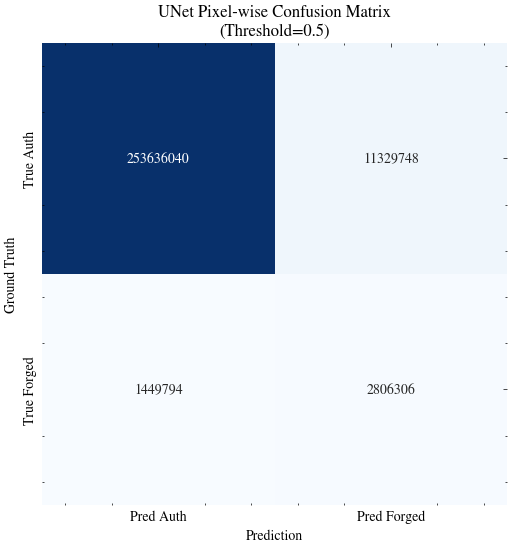

In [ ]:
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'no-latex'])

# Load pre-trained weights (change epoch number as needed)
model = get_model().to(CFGA.device)
model.load_state_dict(torch.load("UNet_ResNet34_SCSE_ASPP_E10.pt", map_location=CFGA.device))

# 1. Run Evaluation
thresh = 0.5
oF1, cm, results_df, pixel_metrics = evaluate_with_official_metric(
    model, loaders['val_f'], loaders['val_a'], CFGA.device, thresh=thresh
)

# 2. Plot Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Auth', 'Pred Forged'],
            yticklabels=['True Auth', 'True Forged'], ax=ax)

ax.set_title(f"UNet Pixel-wise Confusion Matrix\n(Threshold={thresh})")
ax.set_ylabel('Ground Truth')
ax.set_xlabel('Prediction')
ax.tick_params(left=False, bottom=False)
plt.show()

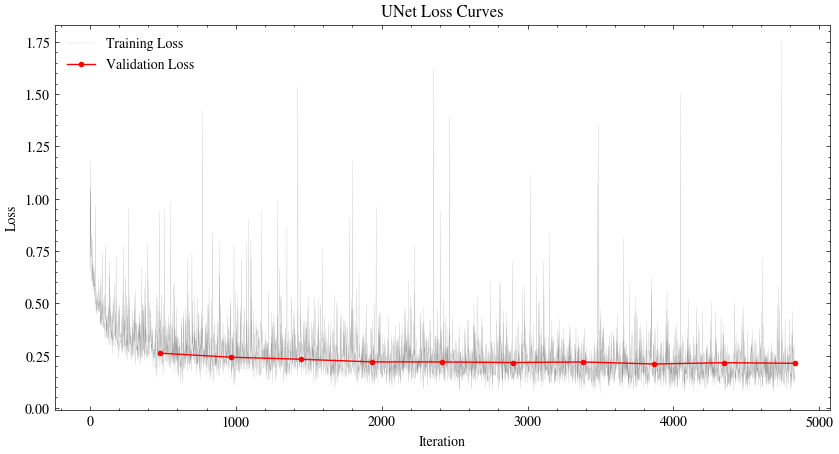

In [ ]:
if 'batch_log' not in dir() or len(batch_log) == 0:
    batch_csv = Path(f"{CFGA.model_name}_batch_losses.csv")
    epoch_csv = Path(f"{CFGA.model_name}_epoch_metrics.csv")
    if batch_csv.exists() and epoch_csv.exists():
        batch_log = pd.read_csv(batch_csv)["batch_loss"].tolist()
        epoch_log = pd.read_csv(epoch_csv).to_dict('records')

if 'batch_log' in dir() and len(batch_log) > 0 and 'epoch_log' in dir() and len(epoch_log) > 0:
    # Create iteration-indexed dataframe for batch losses
    df = pd.DataFrame({"iteration": range(1, len(batch_log) + 1), "loss": batch_log})

    # Calculate validation loss positions (at end of each epoch)
    batches_per_epoch = len(batch_log) // len(epoch_log)
    val_iters = [(i + 1) * batches_per_epoch for i in range(len(epoch_log))]
    val_vals = [e["val_loss"] for e in epoch_log]

    plt.figure(figsize=(10, 5))
    plt.plot(df["iteration"], df["loss"], label="Training Loss", color="gray", linewidth=0.1)
    plt.plot(val_iters, val_vals, label="Validation Loss", color="red", linewidth=1, marker='o', markersize=3, zorder=5)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("UNet Loss Curves")
    plt.legend()
    plt.savefig('unet_losscurve.pdf', bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("Training logs not found. Please ensure CSVs exist or 'batch_log'/'epoch_log' are populated.")

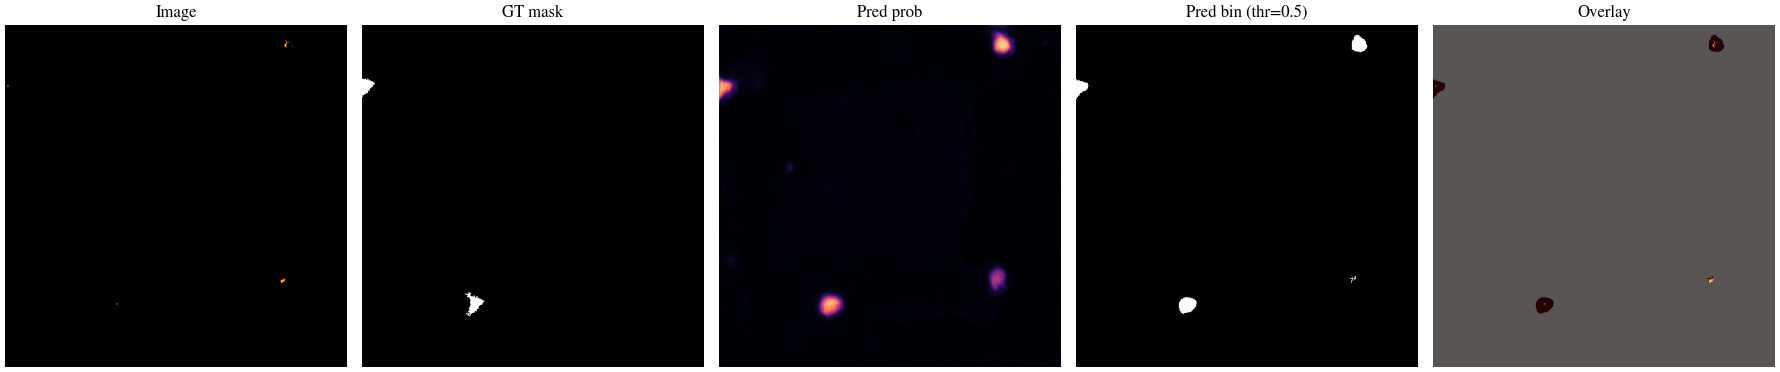

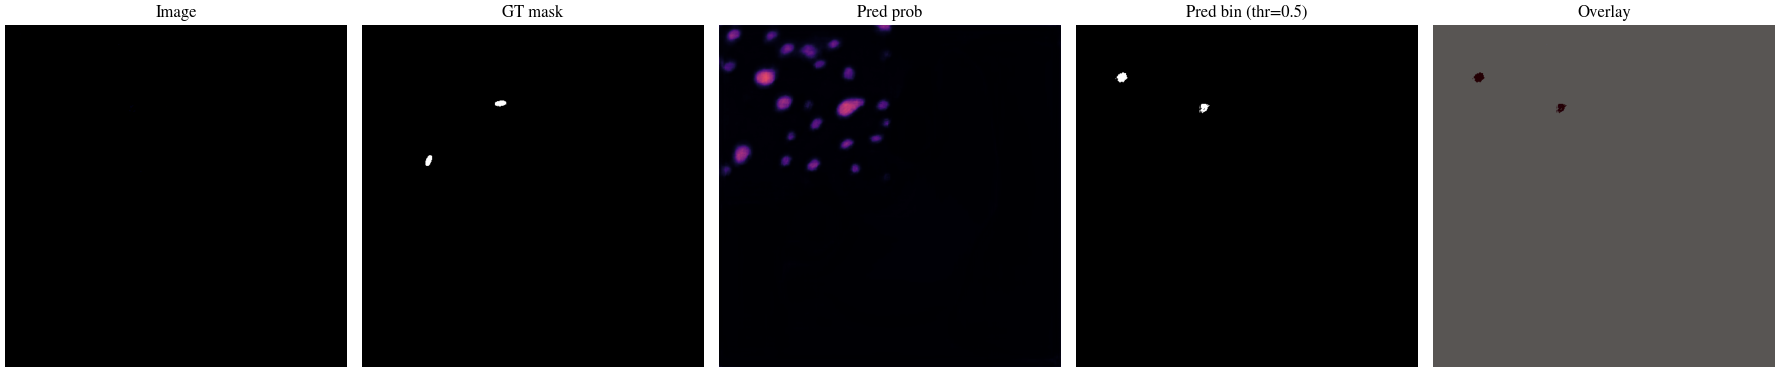

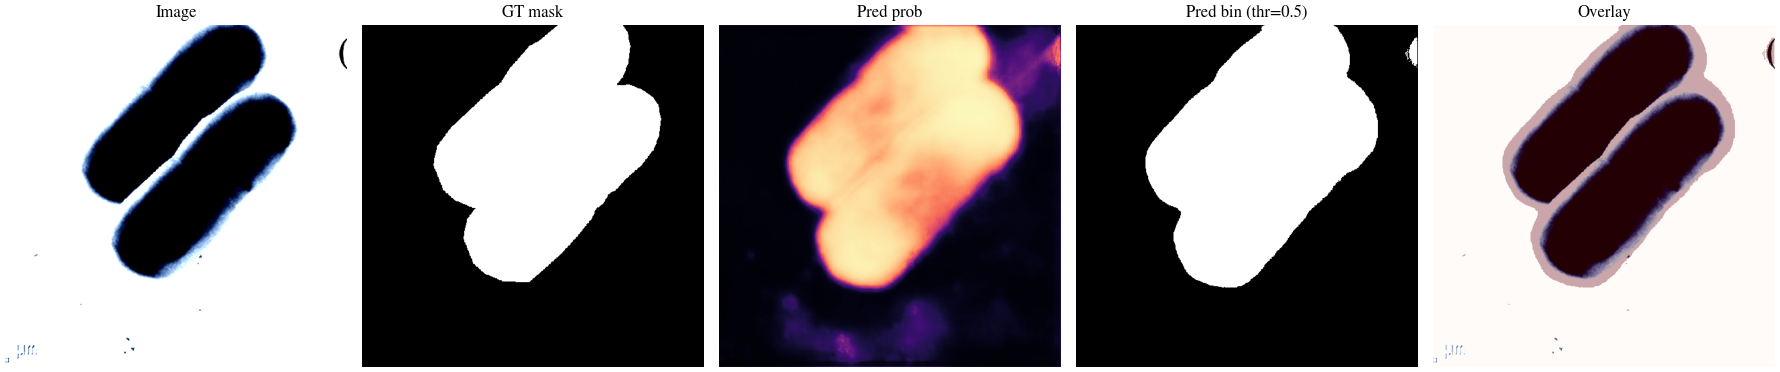

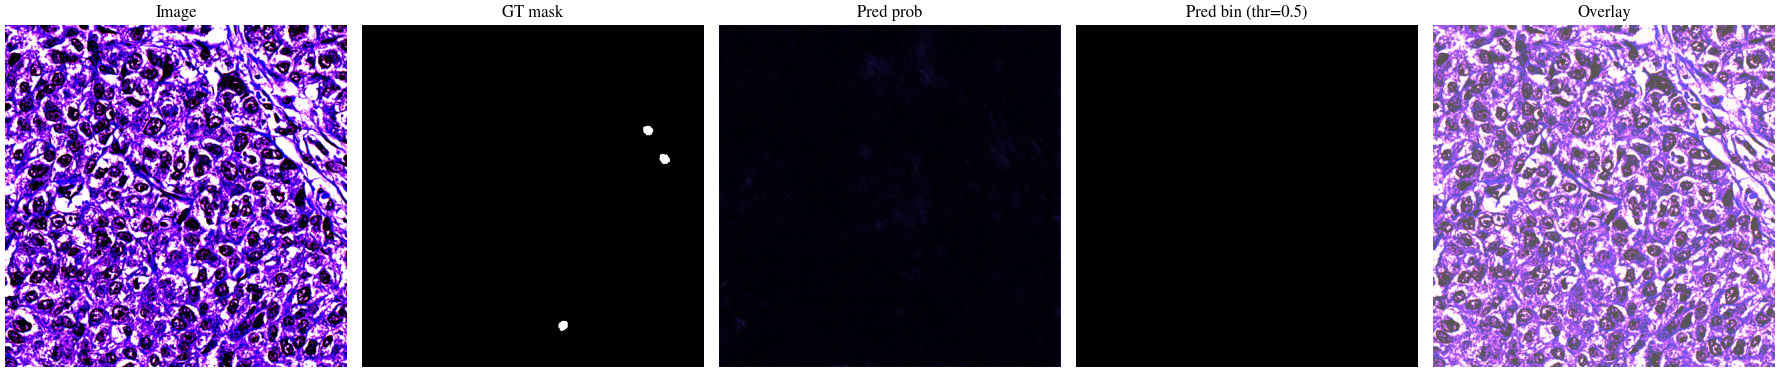

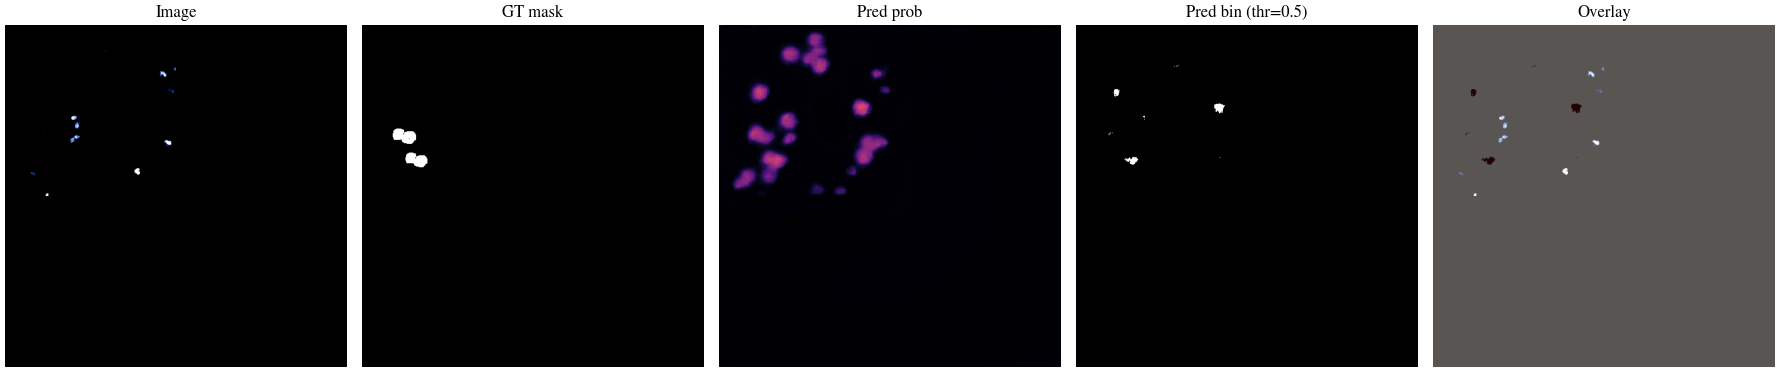

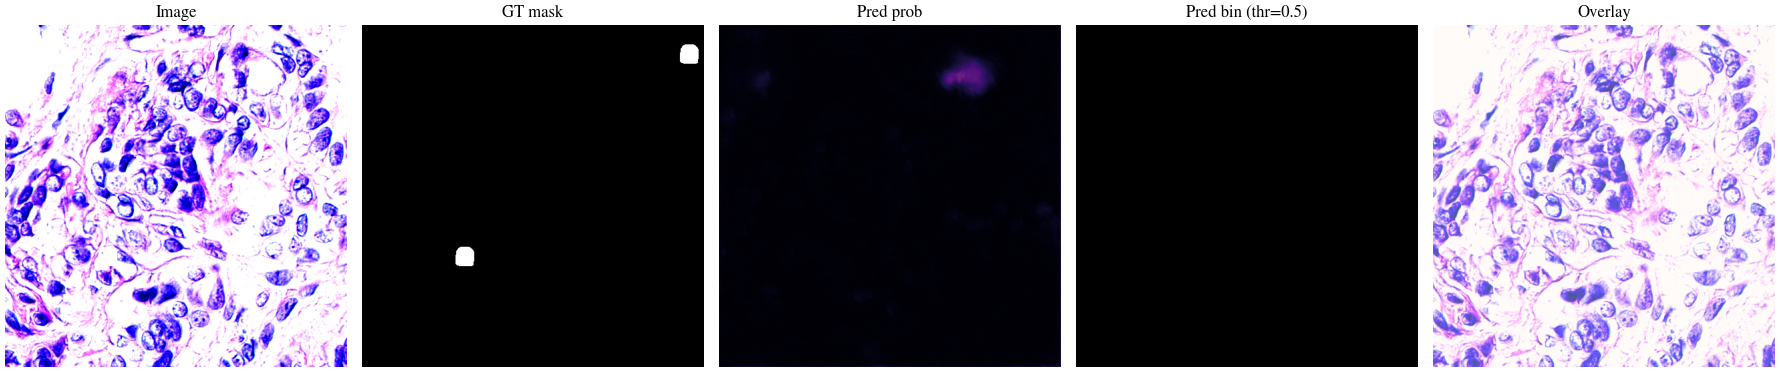

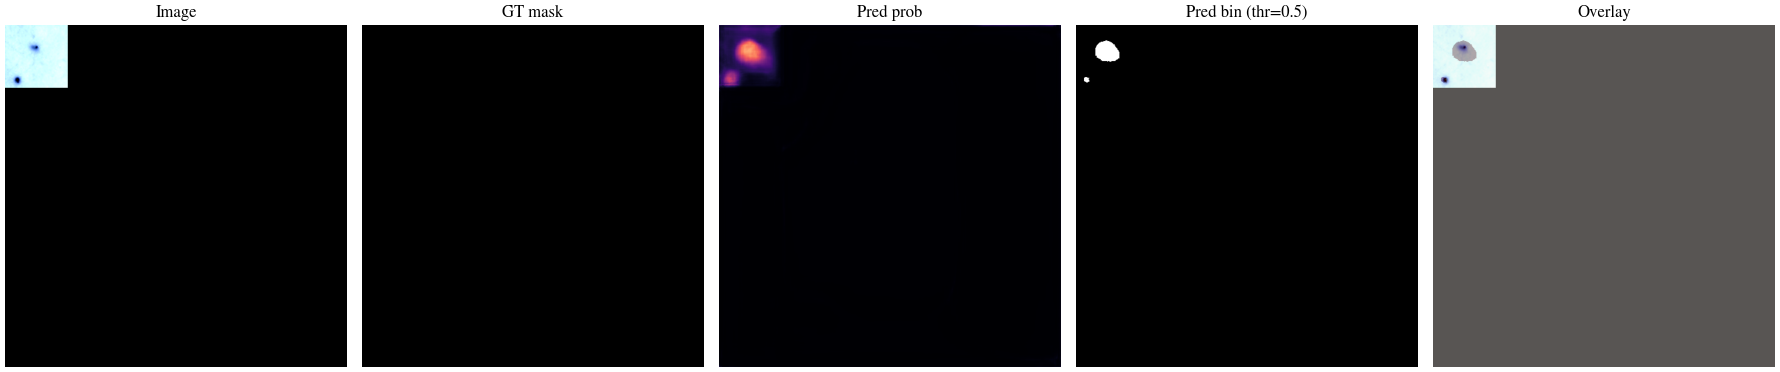

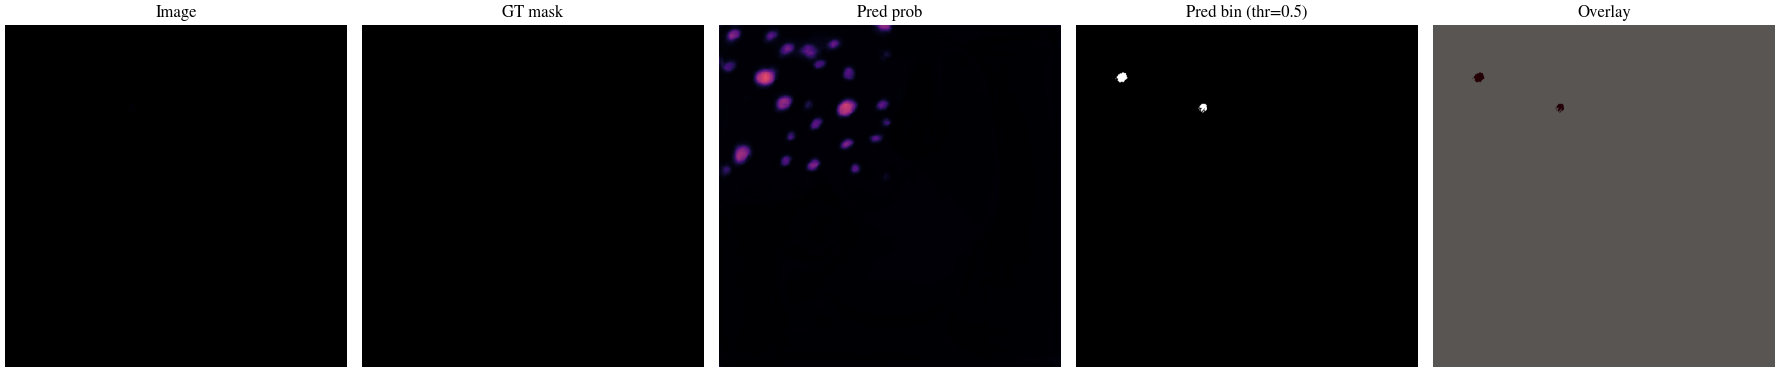

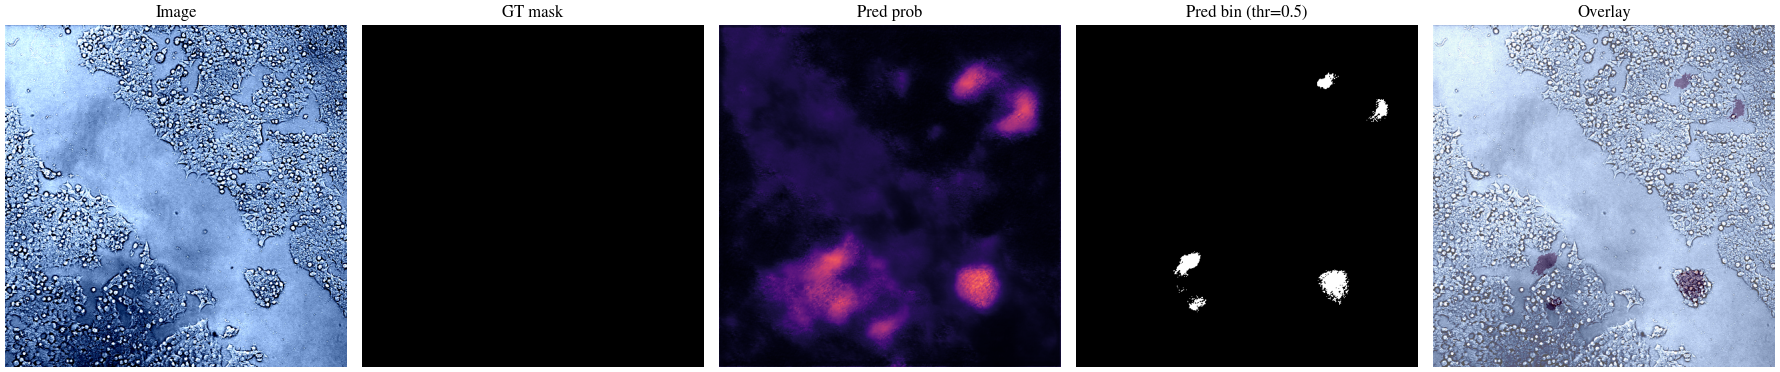

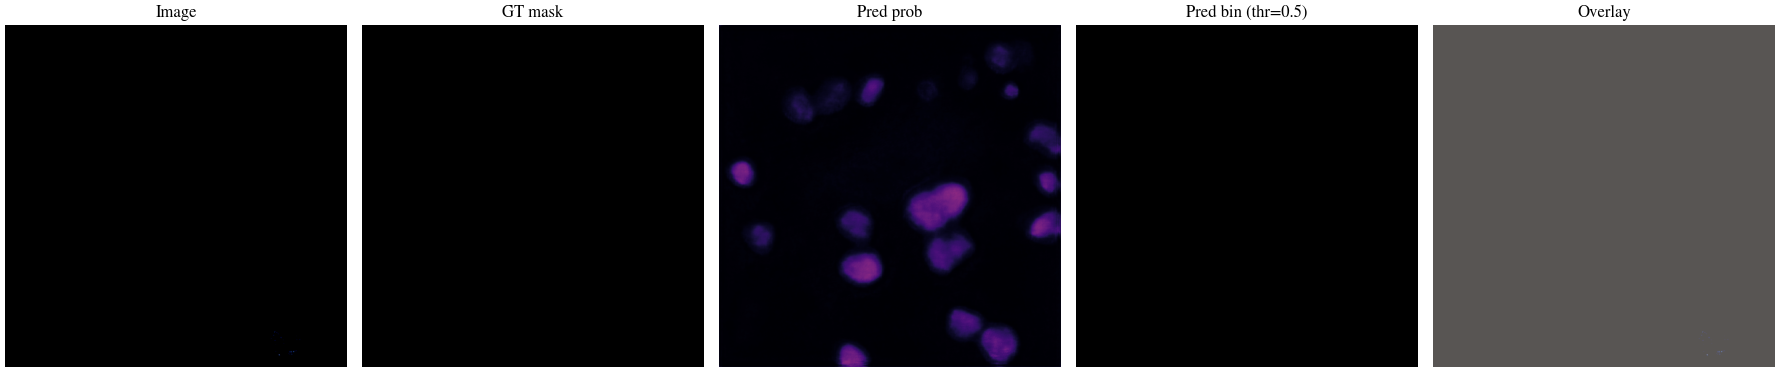

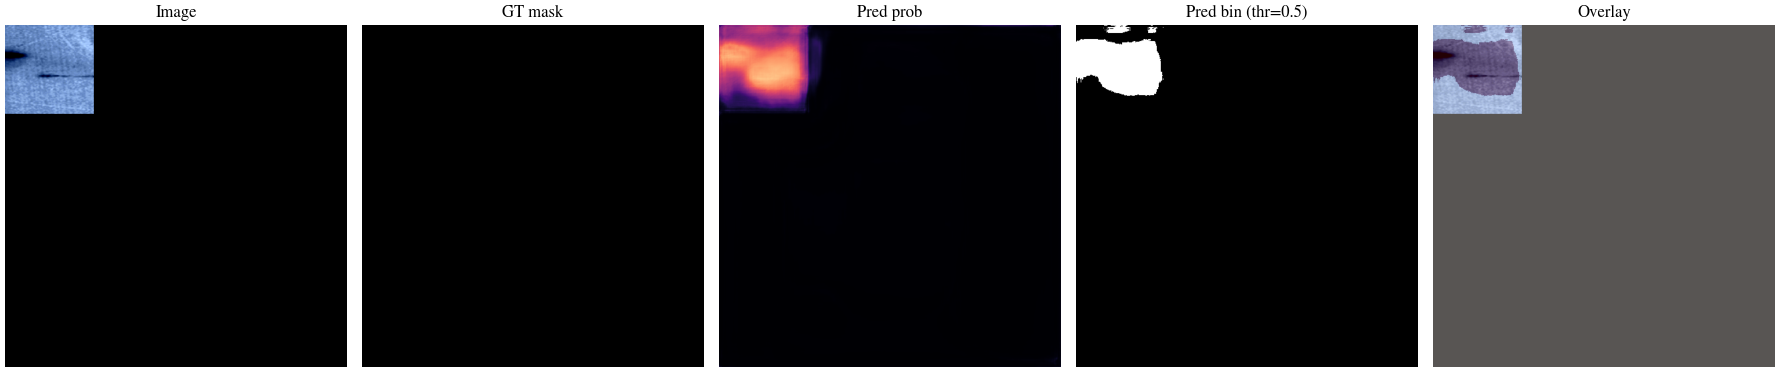

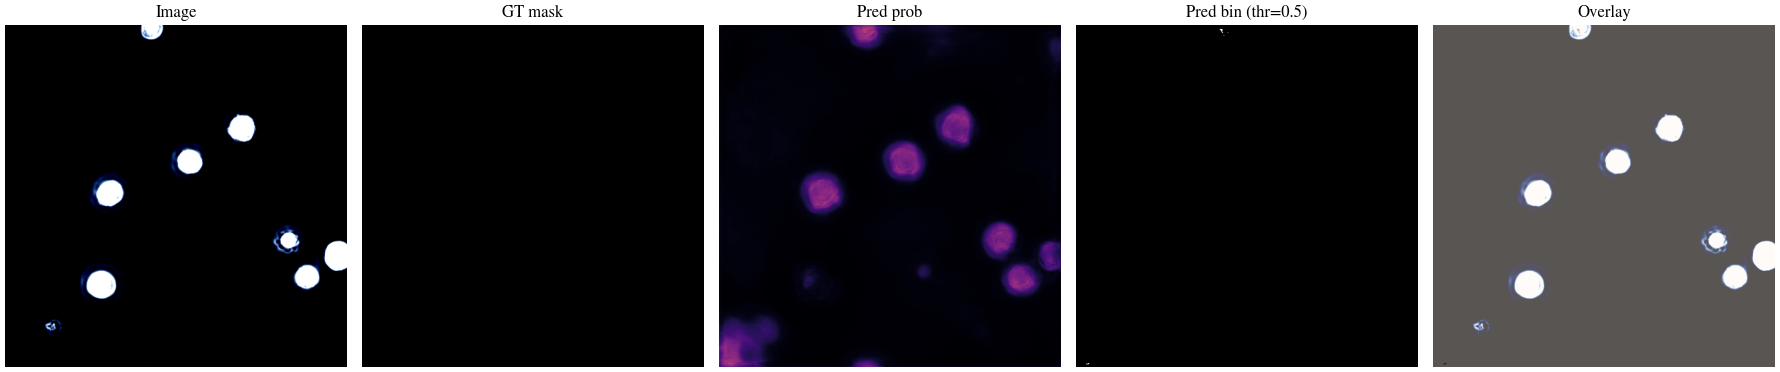

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def show_predictions(model, loader, device, n=6, thr=0.5):
    model.eval()
    batch = next(iter(loader))
    imgs, gts = batch
    imgs = imgs.to(device)
    gts = gts.to(device)

    logits = model(imgs)
    probs = torch.sigmoid(logits)              # (B,1,H,W)
    preds = (probs > thr).float()              # (B,1,H,W)

    B = min(n, imgs.size(0))
    for i in range(B):
        img = imgs[i].detach().cpu().permute(1,2,0).numpy()
        gt  = gts[i,0].detach().cpu().numpy()
        pr  = probs[i,0].detach().cpu().numpy()
        pb  = preds[i,0].detach().cpu().numpy()

        fig, ax = plt.subplots(1, 5, figsize=(18, 4))

        ax[0].imshow(img)
        ax[0].set_title("Image")
        ax[0].axis("off")

        ax[1].imshow(gt, cmap="gray")
        ax[1].set_title("GT mask")
        ax[1].axis("off")

        ax[2].imshow(pr, cmap="magma", vmin=0, vmax=1)
        ax[2].set_title("Pred prob")
        ax[2].axis("off")

        ax[3].imshow(pb, cmap="gray")
        ax[3].set_title(f"Pred bin (thr={thr})")
        ax[3].axis("off")

        # overlay
        ax[4].imshow(img)
        ax[4].imshow(pb, alpha=0.35, cmap="Reds")
        ax[4].set_title("Overlay")
        ax[4].axis("off")

        plt.tight_layout()
        plt.show()

show_predictions(model, loaders["val_f"], CFGA.device, n=6, thr=0.5)

show_predictions(model, loaders["val_a"], CFGA.device, n=6, thr=0.5)
